# Running EM on the birdsong corpus

## Getting set up

In [1]:
import markhov
import em
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Read in the birdsong corpus

In [2]:
f=open('../corpus/cath8.txt','r')
corpus = f.readlines()
f.close()
corpus = [line.rstrip('\n') for line in corpus]


Create a transition grammar for the corpus

In [4]:
trans = {'[':[]}
for s in corpus:
    s=['[']+s.split(' ')
    for i in range(1,len(s)):
        trans[s[i-1]]=trans.get(s[i-1],[])
        if s[i] not in trans[s[i-1]]:
            trans[s[i-1]].append(s[i])


Operations FSA

In [5]:
ops = {'S':{'NotCL':['mg']}, # from start we have to merge
       'NotCL':{'NotCL':['mg','copy'], # this state is the state in which the last "special" operation was *not* Clear. 
                #Either we've done none or the last was copy. From here we can do everything including end
               'CLEAR_S':['clear'], # go here to clear the buffer
               'F':['end'] # go here to end
           },
       'CLEAR_S':{'CLEAR':['mg']}, # this is where we've just cleared. Buffer is empty so you can only Merge
       'CLEAR':{'CLEAR':['mg'], # the last special op was Clear so we can Copy or Merge.
                'NotCL':['copy'] # if we Copy, the last special op was Copy so go to NotCL
            },
       'F':{} #final state
   }


## Expectation Maximisation time!

In [28]:
n = 10 # number of EM iterations to do

In [43]:
history=em.em_rabbit(corpus,trans,ops,n) # run EM

Display the results

In [8]:
import pandas as pd

Make the rules into a simpler list

In [9]:
rules=[]
for lhs in ops:
    for rhs in ops[lhs]:
        for e in ops[lhs][rhs]:
            rules.append(('%s->%s %s'%(lhs,e,rhs),(lhs,rhs,e)))

Put them and their updating probabilities into a table

In [44]:
tab=[]
for (rule,(lhs,rhs,e)) in rules:
    thisrule={'rule':rule}
    for i in range(n):
        p=history[i]['fsa'][lhs][rhs][e]
        thisrule["p.iteration%i"%i]=p
    tab.append(thisrule)

Use pandas to make the table into a datafram

In [45]:
df = pd.DataFrame(tab)

In [46]:
df

,p.iteration0,p.iteration1,p.iteration2,p.iteration3,p.iteration4,p.iteration5,p.iteration6,p.iteration7,p.iteration8,p.iteration9,rule
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,S->mg NotCL
1,-0.443158,-0.929205,-1.056298,-1.243497,-1.432992,-1.586403,-1.756025,-1.930085,-2.047529,-2.156339,CLEAR->mg CLEAR
2,-1.027238,-0.502308,-0.427313,-0.340203,-0.272588,-0.228986,-0.189624,-0.156813,-0.138175,-0.123013,CLEAR->copy NotCL
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CLEAR_S->mg CLEAR
4,-1.666776,-1.855825,-2.385957,-3.039039,-3.738753,-4.361625,-4.864008,-5.268519,-5.638660,-5.985615,NotCL->clear CLEAR_S
5,-1.040215,-1.715817,-1.863511,-1.960902,-2.008577,-2.028673,-2.037770,-2.042332,-2.044921,-2.046500,NotCL->end F
6,-0.914909,-0.467497,-0.304080,-0.217183,-0.175808,-0.157791,-0.149491,-0.145290,-0.142825,-0.141289,NotCL->mg NotCL
7,-2.860972,-3.289020,-4.195018,-5.019964,-5.726741,-6.374822,-7.111665,-7.952158,-8.829384,-9.716263,NotCL->copy NotCL


In [47]:
df.to_csv('ops_%s.csv'%('oct_22_2016_aaa')) # print to file

Same for the transitions

In [48]:
bigrams=[]
for lhs in trans:
    for rhs in trans[lhs]:
        bigrams.append(('%s,%s'%(lhs,rhs),(lhs,rhs)))

In [49]:
tab=[]
for (bi,(lhs,rhs)) in bigrams:
    thisrule={'rule':bi}
    for i in range(n):
        p=history[i]['trans_probs'][lhs][rhs]
        thisrule["p.iteration%i"%i]=p
    tab.append(thisrule)

In [50]:
df_bis = pd.DataFrame(tab)

In [51]:
df_bis

,p.iteration0,p.iteration1,p.iteration2,p.iteration3,p.iteration4,p.iteration5,p.iteration6,p.iteration7,p.iteration8,p.iteration9,rule
0,-2.204187,-2.452650,-2.544992,-2.710508,-2.931781,-2.997924,-3.013293,-3.019347,-3.022380,-3.024275,"aua,aiz"
1,-1.960518,-0.505210,-0.509017,-0.653559,-0.861706,-0.922232,-0.935649,-0.940773,-0.943353,-0.945045,"aua,ats"
2,-4.432601,-3.743457,-2.832574,-1.652194,-1.059631,-0.951459,-0.929442,-0.921142,-0.917014,-0.914372,"aua,aua"
3,-3.138267,-2.858116,-2.950457,-3.115973,-3.337246,-3.403389,-3.418758,-3.424812,-3.427845,-3.429740,"aua,amb"
4,-4.519194,-3.551263,-3.643604,-3.809120,-4.030394,-4.096537,-4.111905,-4.117960,-4.120992,-4.122888,"aua,aje"
5,-1.761295,-2.858116,-2.950457,-3.115973,-3.337246,-3.403389,-3.418758,-3.424812,-3.427845,-3.429740,"aua,aiy"
6,-4.062304,-3.551263,-3.643604,-3.809120,-4.030394,-4.096537,-4.111905,-4.117960,-4.120992,-4.122888,"aua,aib"
7,-1.739529,-3.551263,-3.643604,-3.809120,-4.030394,-4.096537,-4.111905,-4.117960,-4.120992,-4.122888,"aua,ban"
8,-3.006667,-3.551263,-3.643604,-3.809120,-4.030394,-4.096537,-4.111905,-4.117960,-4.120992,-4.122888,"aua,awi"
9,-1.861272,-3.551263,-3.643604,-3.809120,-4.030394,-4.096537,-4.111905,-4.117960,-4.120992,-4.122888,"aua,abu"


In [52]:
df_bis.to_csv('trans_%s.csv'%('oct_22_2016_cath8'))

### Calculate the log likelihood of the corpus given the trained grammar

This is the ll of the corpus at the end of training:

In [54]:
# parse the corpus
parsed_corpus=em.parse_corpus(corpus,trans,ops)

In [55]:
markhov.ll_corpus(parsed_corpus,history[-1]['trans_probs'],history[-1]['fsa'])

-71987.852338499171

Make a dataframe of the LL of the corpus throughout training:

In [56]:
tab=[]
for i in range(n):
    this_iter={'iteration':i,
               'likelihood':markhov.ll_corpus(parsed_corpus,history[i]['trans_probs'],history[i]['fsa'])}
    tab.append(this_iter)

In [57]:
df_lls=pd.DataFrame(tab)

In [58]:
df_lls

,iteration,likelihood
0,0,-83479.054206
1,1,-56979.172078
2,2,-56564.420713
3,3,-58080.117923
4,4,-60376.565601
5,5,-62685.565536
6,6,-64794.582005
7,7,-66713.681211
8,8,-68522.550018
9,9,-70270.048422


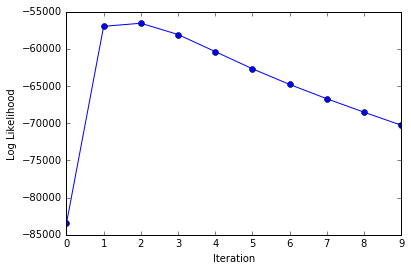

In [59]:
plot(df_lls["iteration"],df_lls["likelihood"],'o-')
xlabel("Iteration")
ylabel("Log Likelihood")

In [42]:
reload(em)

<module 'em' from 'em.py'>